# Faster R-CNN with ResNet backbone

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pretrained model
model = fasterrcnn_resnet50_fpn_v2(pretrained=True)


classes = ["trafficlight", "stop", "speedlimit", "crosswalk"]
num_classes = len(classes) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


c:\Users\alihu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alihu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import random
import torchvision.transforms.functional as F

class CustomCompose:
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class CustomToTensor:
    def __call__(self, image, target):
        # Convert PIL image to tensor
        image = F.to_tensor(image)
        return image, target

class CustomRandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob
        
    def __call__(self, image, target):
        if random.random() < self.prob:
            # Flip image
            image = F.hflip(image)
            
            # Need to flip boxes too
            if "boxes" in target:
                h, w = image.shape[-2:]
                boxes = target["boxes"]
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # flip x coordinates
                target["boxes"] = boxes
                
        return image, target

class RoadSignDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None, class_mapping=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        
        # If class_mapping is not provided, create a default one or initialize empty
        # This maps class names to class indices
        if class_mapping is None:
            self.class_to_idx = {}
        else:
            self.class_to_idx = class_mapping
            
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        img = Image.open(img_path).convert("RGB")
        
        # Get corresponding XML annotation file
        xml_filename = os.path.splitext(img_filename)[0] + '.xml'
        xml_path = os.path.join(self.annotations_dir, xml_filename)
        
        # Parse XML
        boxes = []
        labels = []
        
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get image size from the XML
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        
        # Get all object annotations
        for obj in root.findall('object'):
            # Get class name and convert to index
            name = obj.find('name').text
            
            # Add class to mapping if not already there
            if name not in self.class_to_idx:
                self.class_to_idx[name] = len(self.class_to_idx)
                
            # Map class name to class id
            class_id = self.class_to_idx[name]
            
            # Get bounding box coordinates
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_id)
        
        # Convert to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        # Apply transforms if any
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

# Creating Datasets

In [ ]:
def get_transform(train):
    transforms = []
    # Convert PIL image to tensor
    transforms.append(CustomToTensor())
    if train:
        # Add training augmentations here
        transforms.append(CustomRandomHorizontalFlip())
    return CustomCompose(transforms)

# Define your class mapping (class name to index)
class_map = {"trafficlight": 1,
                           "stop": 2,
                           "speedlimit": 3,
                           "crosswalk": 4}

# Create datasets for train/val/test
train_dataset = RoadSignDataset(
    images_dir="data/images/train",
    annotations_dir="road-sign-detection/annotations",
    transforms=get_transform(train=True)
)
train_dataset.class_to_idx = class_map

val_dataset = RoadSignDataset(
    images_dir="data/images/val",
    annotations_dir="road-sign-detection/annotations",
    transforms=get_transform(train=False)
)
val_dataset.class_to_idx = class_map

test_dataset = RoadSignDataset(
    images_dir="data/images/test",
    annotations_dir="road-sign-detection/annotations",
    transforms=get_transform(train=False)
)
test_dataset.class_to_idx = class_map

In [17]:
import torch.optim as optim

def collate_fn(batch):
    return tuple(zip(*batch))

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    
    # Get total number of batches for reporting
    total_batches = len(data_loader)
    print(f"Starting training epoch with {total_batches} batches")
    
    for batch_idx, (images, targets) in enumerate(data_loader):
        # Print progress every 10 batches (or adjust as needed)
        if batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx}/{total_batches} ({batch_idx/total_batches*100:.1f}%)")
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Print loss occasionally
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx} loss: {losses.item():.4f}")
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch complete. Average loss: {avg_loss:.4f}")
    
    return avg_loss

In [19]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    
    # Switch model to training mode temporarily to get losses during evaluation
    # This is a workaround since evaluation mode returns detections, not losses
    model.train()
    
    with torch.no_grad():  # Still don't compute gradients
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass with targets to get losses
            loss_dict = model(images, targets)
            
            # Process the loss dictionary
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
            else:
                # Handle unexpected return types
                print(f"Warning: Unexpected return type from model: {type(loss_dict)}")
                continue
            
            total_loss += losses.item()
    
    # Switch model back to eval mode
    model.eval()
    
    return total_loss / len(data_loader)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


num_epochs = 1

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    
    # Update the learning rate
    lr_scheduler.step()
    
    # Evaluate on the validation dataset
    val_loss = evaluate(model, val_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # # Save the model checkpoint
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

print("Training complete!")

Starting training epoch with 701 batches
Processing batch 0/701 (0.0%)
  Batch 0 loss: 1.8076
Processing batch 10/701 (1.4%)
  Batch 10 loss: 0.1792
Processing batch 20/701 (2.9%)
  Batch 20 loss: 0.1532
Processing batch 30/701 (4.3%)
  Batch 30 loss: 0.0679
Processing batch 40/701 (5.7%)
  Batch 40 loss: 0.4167
Processing batch 50/701 (7.1%)
  Batch 50 loss: 0.0193
Processing batch 60/701 (8.6%)
  Batch 60 loss: 0.0752
Processing batch 70/701 (10.0%)
  Batch 70 loss: 0.0803
Processing batch 80/701 (11.4%)
  Batch 80 loss: 0.0344
Processing batch 90/701 (12.8%)
  Batch 90 loss: 0.0347
Processing batch 100/701 (14.3%)
  Batch 100 loss: 0.0940
Processing batch 110/701 (15.7%)
  Batch 110 loss: 0.0424
Processing batch 120/701 (17.1%)
  Batch 120 loss: 0.0441
Processing batch 130/701 (18.5%)
  Batch 130 loss: 0.0413
Processing batch 140/701 (20.0%)
  Batch 140 loss: 0.0477
Processing batch 150/701 (21.4%)
  Batch 150 loss: 0.0370
Processing batch 160/701 (22.8%)
  Batch 160 loss: 0.1236
Pr

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

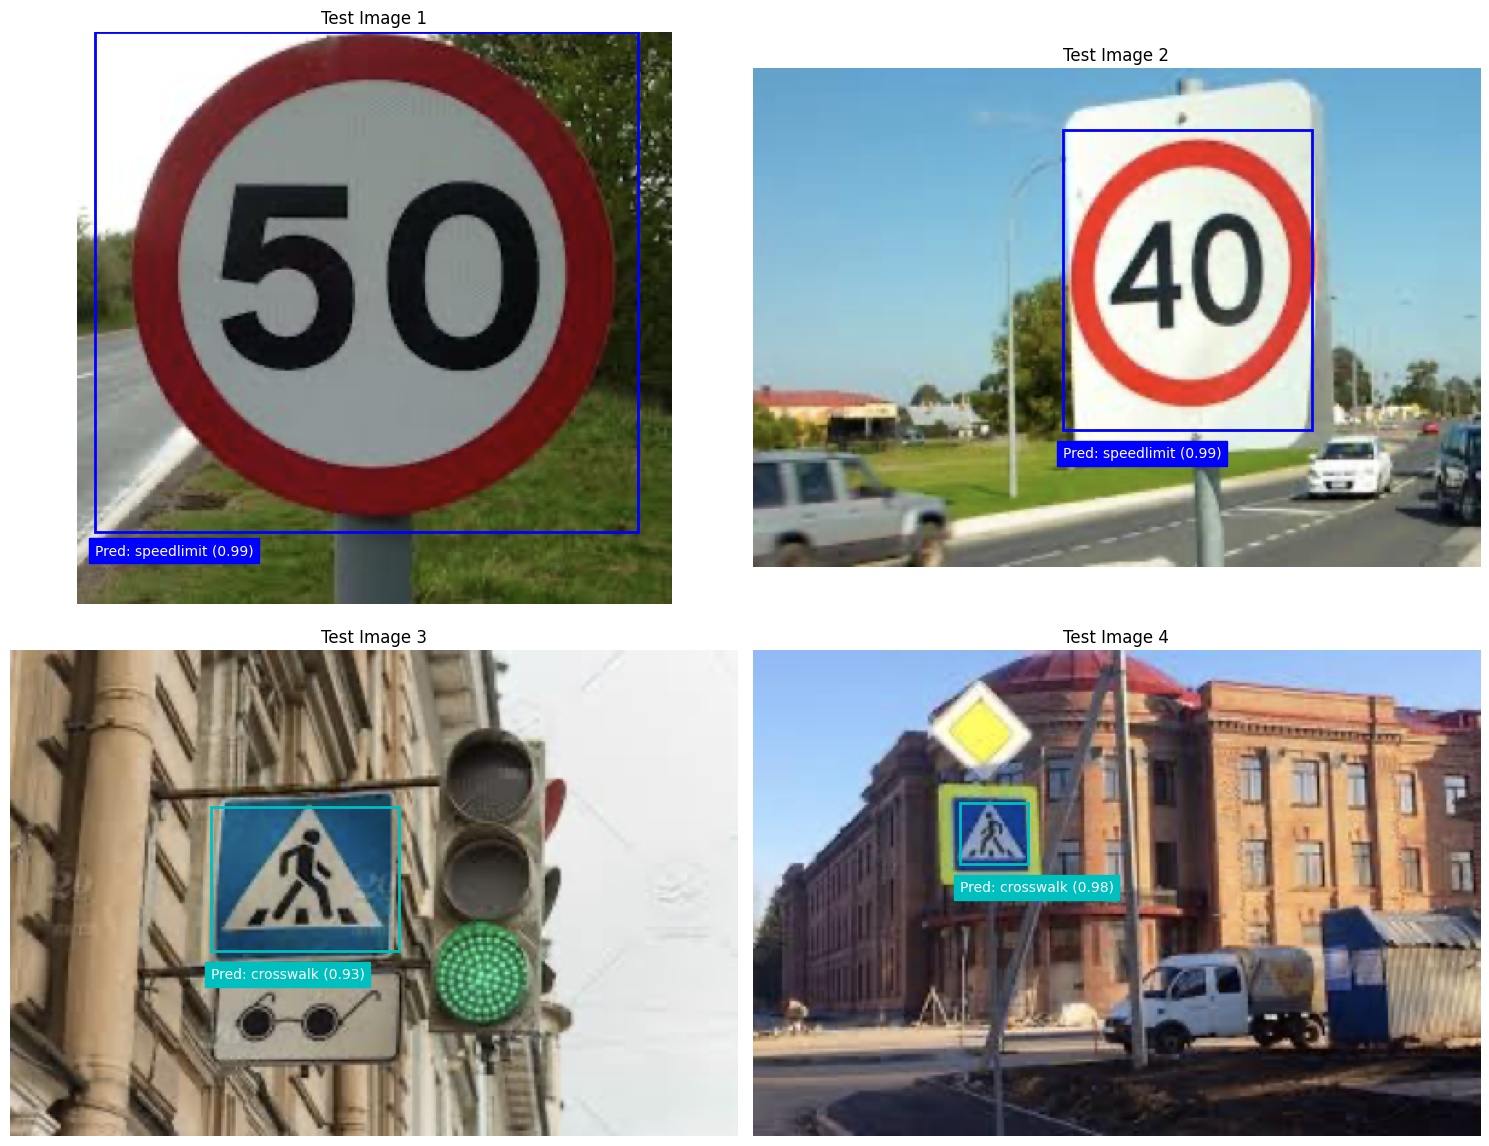

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def test_model_qualitatively(model, test_loader, device, num_samples=4, confidence_threshold=0.5):
    """
    Qualitatively test the model on a few samples from the test loader
    
    Args:
        model: The trained model
        test_loader: DataLoader for test dataset
        device: Device to run inference on
        num_samples: Number of images to test (default: 4)
        confidence_threshold: Minimum confidence score to display a detection
    """
    model.eval()
    
    # Reverse the class mapping to get labels
    idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
    
    # Define colors for different classes
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Get samples from test loader
    samples_seen = 0
    
    for images, targets in test_loader:
        if samples_seen >= num_samples:
            break
            
        # Get the image
        image = images[0].to(device)
        target = targets[0]
        
        # Convert tensor to numpy for display
        orig_image = F.to_pil_image(image.cpu())
        
        # Perform detection
        with torch.no_grad():
            prediction = model([image])
        
        # Get predictions
        pred_boxes = prediction[0]['boxes'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()
        pred_labels = prediction[0]['labels'].cpu().numpy()
        
        # Filter by confidence
        keep = pred_scores > confidence_threshold
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]
        
        # Plot the image
        ax = axes[samples_seen]
        ax.imshow(orig_image)
        
        # Plot ground truth boxes (solid lines)
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()
        
        for box, label_idx in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            label = idx_to_class[label_idx.item()]
            color = colors[label_idx % len(colors)]
            
        # Plot predicted boxes (dashed lines)
        for box, score, label_idx in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            label = idx_to_class[label_idx.item()]
            color = colors[label_idx % len(colors)]
            
            # Draw prediction box with dashed line
            rect = patches.Rectangle((x1, y1), width, height, 
                                    linewidth=2, edgecolor=color, 
                                    facecolor='none', linestyle='-')
            ax.add_patch(rect)
            ax.text(x1, y2+15, f"Pred: {label} ({score:.2f})", 
                   color='white', backgroundcolor=color, fontsize=10)
            
        ax.set_title(f"Test Image {samples_seen+1}")
        ax.axis('off')
        
        samples_seen += 1
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage example
model.to(device)
fig = test_model_qualitatively(model, test_loader, device)

In [25]:
import torch
from tqdm import tqdm
import numpy as np
from collections import defaultdict

def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    """
    Quantitatively evaluate a detection model on a test set
    
    Args:
        model: The trained model
        data_loader: DataLoader for test dataset
        device: Device to run inference on
        iou_threshold: IoU threshold for considering a detection as correct (default: 0.5)
        
    Returns:
        dict: Dictionary containing precision, recall, and mAP metrics
    """
    model.eval()
    
    # Get the class names
    idx_to_class = {v: k for k, v in data_loader.dataset.class_to_idx.items()}
    num_classes = len(idx_to_class) + 1  # +1 for background
    
    # Structures to store detections and ground truths
    all_detections = [[] for _ in range(num_classes)]
    all_ground_truths = [[] for _ in range(num_classes)]
    
    # Lists to store precision and recall values for each class
    class_precision = defaultdict(list)
    class_recall = defaultdict(list)
    class_ap = {}
    
    print("Evaluating model on test set...")
    
    # Iterate through all test samples
    for images, targets in tqdm(data_loader):
        images = list(img.to(device) for img in images)
        
        # Run inference
        with torch.no_grad():
            predictions = model(images)
        
        # Process each image
        for i, (prediction, target) in enumerate(zip(predictions, targets)):
            pred_boxes = prediction['boxes'].cpu().numpy()
            pred_scores = prediction['scores'].cpu().numpy()
            pred_labels = prediction['labels'].cpu().numpy()
            
            gt_boxes = target['boxes'].cpu().numpy()
            gt_labels = target['labels'].cpu().numpy()
            
            # Store detections and ground truths by class
            for class_id in range(1, num_classes):  # Skip background
                # Get detections for this class
                class_detections = pred_boxes[pred_labels == class_id]
                class_scores = pred_scores[pred_labels == class_id]
                
                # Sort by confidence score
                if len(class_scores) > 0:
                    sort_idx = np.argsort(-class_scores)
                    class_detections = class_detections[sort_idx]
                    class_scores = class_scores[sort_idx]
                
                # Store detections with scores
                for det, score in zip(class_detections, class_scores):
                    all_detections[class_id].append({
                        'box': det,
                        'score': score,
                        'matched': False  # Whether this detection has been matched to a ground truth
                    })
                
                # Get ground truths for this class
                class_gt = gt_boxes[gt_labels == class_id]
                
                # Store ground truths
                for gt in class_gt:
                    all_ground_truths[class_id].append({
                        'box': gt,
                        'matched': False  # Whether this ground truth has been matched to a detection
                    })
    
    # Calculate metrics for each class
    for class_id in range(1, num_classes):  # Skip background
        if len(all_ground_truths[class_id]) == 0:
            # Skip classes with no ground truth
            continue
            
        # Sort detections by score
        detections = sorted(all_detections[class_id], key=lambda x: x['score'], reverse=True)
        
        # Calculate precision and recall at each detection
        tp = 0  # True positives
        fp = 0  # False positives
        
        total_gt = len(all_ground_truths[class_id])
        
        for det in detections:
            matched = False
            
            for gt in all_ground_truths[class_id]:
                if gt['matched']:
                    # This ground truth is already matched to a higher-confidence detection
                    continue
                
                # Calculate IoU between detection and ground truth
                iou = calculate_iou(det['box'], gt['box'])
                
                if iou >= iou_threshold:
                    # Match found
                    matched = True
                    gt['matched'] = True
                    break
            
            if matched:
                tp += 1
            else:
                fp += 1
            
            # Calculate precision and recall at this point
            precision = tp / (tp + fp)
            recall = tp / total_gt
            
            class_precision[class_id].append(precision)
            class_recall[class_id].append(recall)
        
        # Calculate AP for this class
        if len(class_precision[class_id]) > 0:
            # Compute AP using 11-point interpolation
            ap = 0
            for t in np.arange(0, 1.1, 0.1):
                if len(np.array(class_recall[class_id])[np.array(class_recall[class_id]) >= t]) > 0:
                    p = np.max(np.array(class_precision[class_id])[np.array(class_recall[class_id]) >= t])
                    ap += p / 11
            
            class_ap[class_id] = ap
        else:
            class_ap[class_id] = 0
    
    # Overall metrics
    mean_ap = sum(class_ap.values()) / len(class_ap) if class_ap else 0
    class_metrics = {idx_to_class[class_id]: ap for class_id, ap in class_ap.items()}
    
    # Format results
    results = {
        'mAP': mean_ap,
        'AP_by_class': class_metrics,
    }
    
    return results

def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes
    
    Args:
        box1: First box coordinates [x1, y1, x2, y2]
        box2: Second box coordinates [x1, y1, x2, y2]
        
    Returns:
        float: IoU between the two boxes
    """
    # Calculate intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 < x1 or y2 < y1:
        return 0.0
    
    intersection_area = (x2 - x1) * (y2 - y1)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

# Usage example
model.to(device)
results = evaluate_model(model, test_loader, device)

# Print results
print(f"Mean Average Precision (mAP@0.5): {results['mAP']:.4f}")
print("\nAverage Precision by class:")
for class_name, ap in results['AP_by_class'].items():
    print(f"  {class_name}: {ap:.4f}")

Evaluating model on test set...


100%|██████████| 88/88 [00:16<00:00,  5.26it/s]

Mean Average Precision (mAP@0.5): 0.9028

Average Precision by class:
  stop: 1.0000
  speedlimit: 0.8994
  crosswalk: 0.8089
